In [1]:
from utils.CoopEnv import CoopEnv
from utils.IACagent import Agent

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# Set constant hyperparameters
n = 10
num_of_tasks  = 5
num_of_sims = 1
step_limit = 5000

In [4]:
move_space = num_of_tasks
comm_space = 11 # number of divisions to divide range

lower_bound = 0
upper_bound = 1
comm_array = np.linspace(lower_bound, upper_bound, comm_space)
print(len(comm_array))

11


In [5]:
env = CoopEnv(n=n, num_of_tasks=num_of_tasks)

In [6]:
steps_to_complete = np.zeros((num_of_sims, step_limit+1))
comm_rec_actions = np.zeros((step_limit, env.n))
move_rec_actions = np.zeros((step_limit, env.n))

In [7]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        agentlist = {i: Agent(move_space, comm_space) for i in range(env.n)}
        # reset the environment
        observations = env.reset(n=n, num_of_tasks =num_of_tasks )

        # begin training loop
        t = 0
        while t < step_limit:
            print(t, end='\r')

            sys_actions = np.zeros((env.n, 2)) # column 0 for move actions and column 1 for comm actions
            # collect move and comm  action for each agent
            sys_actions = np.array([agentlist[i].choose_action(observations[i]) for i in range(env.n)])

            for i in range(env.n):
                sys_actions[i,1] = comm_array[sys_actions[i,1]]

            next_observations, rewards, termination, info = env.step(sys_actions) # env.step

            comm_rec_actions[t] = sys_actions[:,1] # output from actor (comm head)
            move_rec_actions[t] = sys_actions[:,0]

            for i in range(env.n): # train each agent
                agentlist[i].train(observations[i], sys_actions[i, :], rewards[i], next_observations[i])

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t+1] = (sum(rewards)/env.n) + steps_to_complete[s, t]

            # increment timestep and loop
            t +=1




In [8]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------


In [9]:
np.save(f'n{n}t{num_of_tasks}_cum_rew_{step_limit}steps', steps_to_complete)
np.save(f'n{n}t{num_of_tasks}_actions_{step_limit}steps', comm_rec_actions)

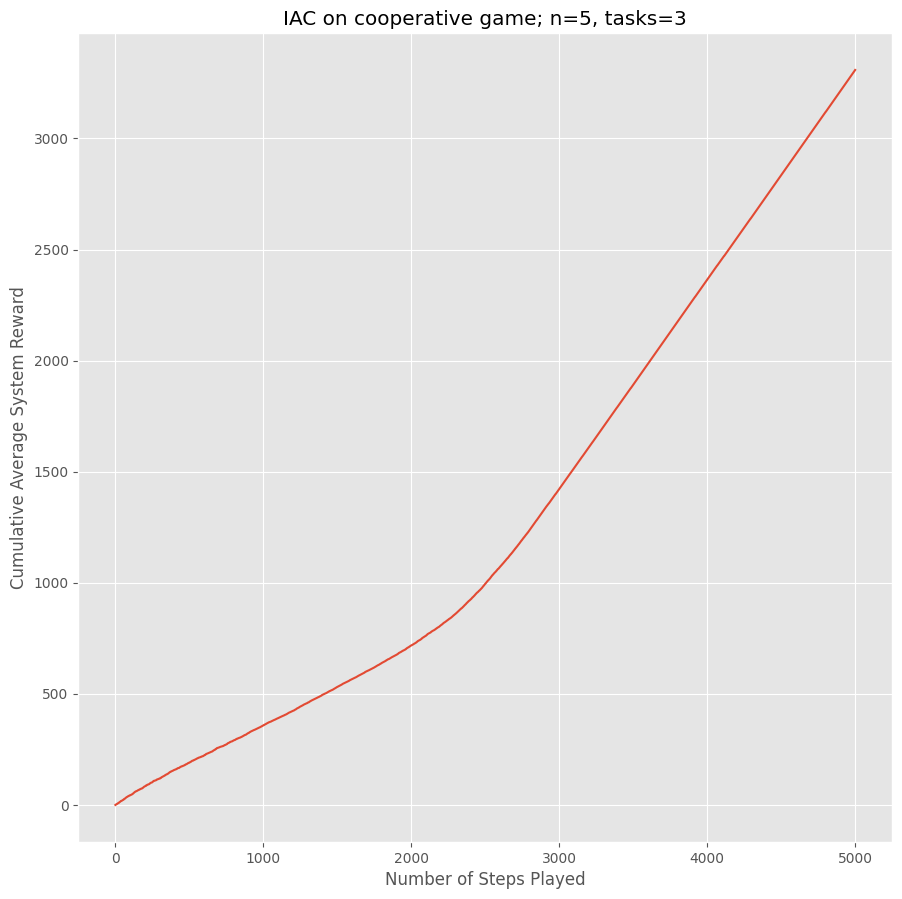

In [26]:
plt.style.use('ggplot')
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)
plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Average System Reward')
plt.title(f'IAC on cooperative game; n={n}, tasks={num_of_tasks}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(b)

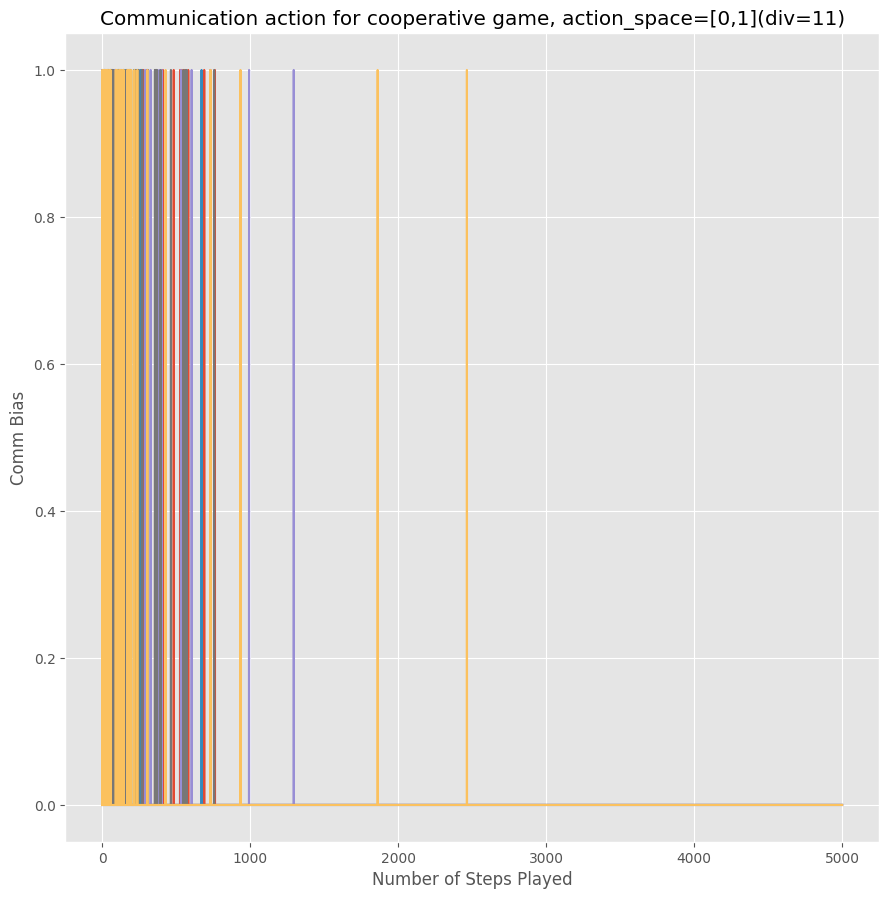

In [27]:
plt.xlabel('Number of Steps Played')
plt.ylabel('Comm Bias')
plt.title(f'Communication action for cooperative game, action_space=[{lower_bound},{upper_bound}](div={comm_space})')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

plt.plot(comm_rec_actions)

In [28]:
# Get coalition structure
print(env.CS)


[{'1', '2'}, {'5'}, {'4', '3'}]
